<a href="https://colab.research.google.com/github/KiKax2/Driver-Behavior-Classification/blob/main/Driver_Behavior_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [4]:
import kagglehub
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Downloading dataset

In [2]:
path = kagglehub.dataset_download("zeyad1mashhour/driver-inattention-detection-dataset")
print("Path to dataset files:", path)


100%|██████████| 373M/373M [00:21<00:00, 18.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/zeyad1mashhour/driver-inattention-detection-dataset/versions/1


# Class names

In [3]:
class_names = ['DangerousDriving', 'Distracted', 'Drinking', 'SafeDriving', 'SleepyDriving', 'Yawn']

# Loading annotations

In [5]:
def load_annotations(file_path):
    annotations = {}
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                try:
                    bbox_class = list(map(int, parts[1].split(',')))
                    annotations[parts[0]] = bbox_class[-1]
                except ValueError:
                    pass
    return annotations

annotation_file_path = os.path.join(path, 'train/_annotations.txt')
annotations = load_annotations(annotation_file_path)

# Loading and preprocessing images

In [6]:
def preprocess_images(folder_path, annotations, target_size=(224, 224)):
    images, labels = [], []
    for image_name, class_id in annotations.items():
        img_path = os.path.join(folder_path, image_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, target_size)
            images.append(img)
            labels.append(class_id)
    return np.array(images), to_categorical(labels, num_classes=len(class_names))

# Preprocessing dataset

In [7]:
train_images_path = os.path.join(path, 'train')
train_images, train_labels = preprocess_images(train_images_path, annotations)
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Defining the model

In [8]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Compiling the model

In [9]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training the model

In [10]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - accuracy: 0.5162 - loss: 101.9952 - val_accuracy: 0.7402 - val_loss: 0.7959
Epoch 2/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.7505 - loss: 0.7366 - val_accuracy: 0.7728 - val_loss: 0.6538
Epoch 3/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.8033 - loss: 0.5865 - val_accuracy: 0.7967 - val_loss: 0.6898
Epoch 4/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.8334 - loss: 0.4754 - val_accuracy: 0.8134 - val_loss: 0.5628
Epoch 5/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.8538 - loss: 0.4109 - val_accuracy: 0.7921 - val_loss: 0.6065
Epoch 6/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.8576 - loss: 0.3856 - val_accuracy: 0.8305 - val_loss: 0.5943
Epoch 7/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.8890 - loss: 0.3087 - val_accuracy: 0.8314 - val_loss: 0.5899
Epoch 8/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.8926 - loss: 0.2814 

# Plot training results

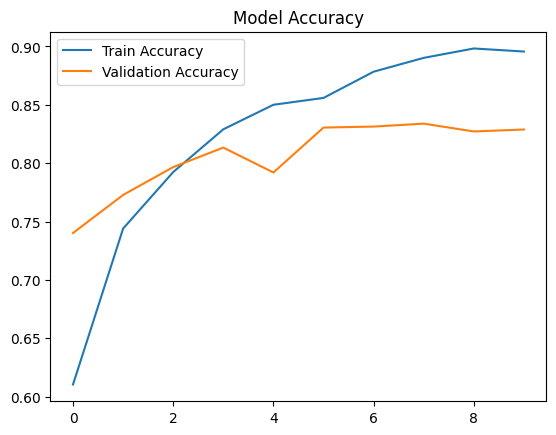

In [11]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

# Function to plot images with actual and predicted labels

In [12]:
def plot_images_with_labels(images, actual_labels, predicted_labels, class_names, grid_size=(3, 3)):
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 12))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i])
            actual_label = class_names[np.argmax(actual_labels[i])]
            predicted_label = class_names[np.argmax(predicted_labels[i])]
            ax.set_title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Resultats

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step


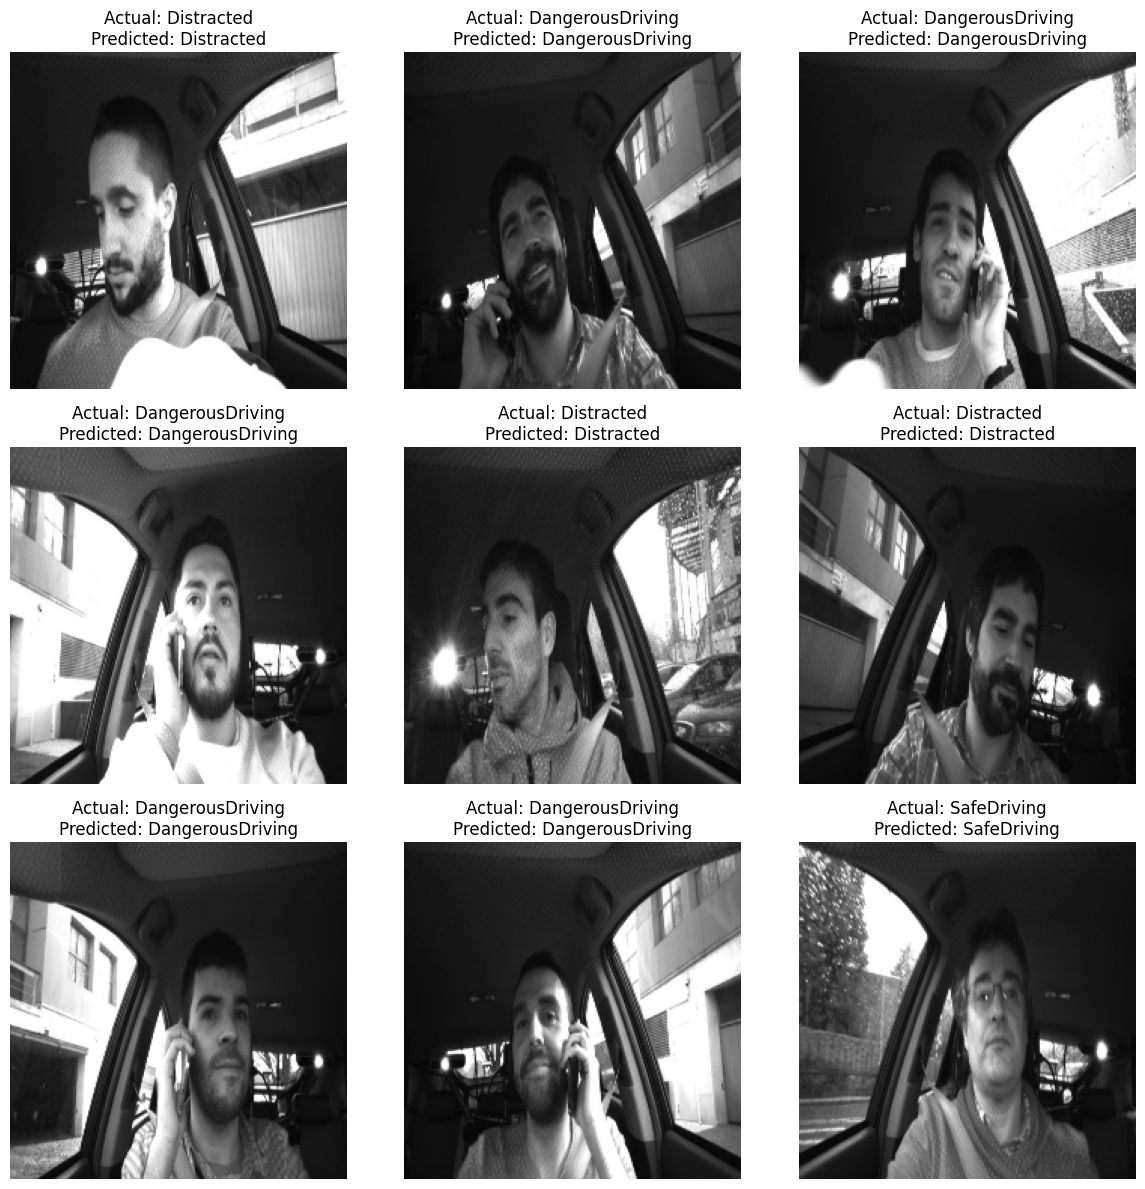

In [13]:
indices = np.random.choice(len(X_val), 9, replace=False)  # Select 9 random images
sample_images = X_val[indices]
sample_actual_labels = y_val[indices]
sample_predicted_labels = model.predict(sample_images)

plot_images_with_labels(sample_images, sample_actual_labels, sample_predicted_labels, class_names)

# Evaluating the model

In [14]:
test_loss, test_accuracy = model.evaluate(X_val, y_val)
print(f'Test Accuracy: {test_accuracy:.2f}')


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8266 - loss: 0.6814
Test Accuracy: 0.83


# Saving the model

In [15]:
model.save('driving_behavior_model_simple.h5')